In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
np.random.seed(10)   
tf.random.set_seed(10)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1] 
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape 
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[85864:92469] 
Y_train_SS = Y_train_SS[85864:92469]
Y_train_V = Y_train_V[85864:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 6605
Validation samples: 13210
Testing samples: 26420


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

Train on 6605 samples, validate on 13210 samples
Epoch 1/100
6176/6605 [===========================>..] - ETA: 0s - loss: 0.1114 - dense_5_loss: 0.0852 - dense_6_loss: 0.0262 - dense_5_mse: 0.0852 - dense_6_mse: 0.0262

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.04748, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 3s 454us/sample - loss: 0.1066 - dense_5_loss: 0.0807 - dense_6_loss: 0.0256 - dense_5_mse: 0.0809 - dense_6_mse: 0.0257 - val_loss: 0.0475 - val_dense_5_loss: 0.0271 - val_dense_6_loss: 0.0204 - val_dense_5_mse: 0.0270 - val_dense_6_mse: 0.0204
Epoch 2/100
6112/6605 [==========================>...] - ETA: 0s - loss: 0.0307 - dense_5_loss: 0.0133 - dense_6_loss: 0.0173 - dense_5_mse: 0.0133 - dense_6_mse: 0.0173
Epoch 2: val_loss improved from 0.04748 to 0.03515, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 2s 259us/sample - loss: 0.0307 - dense_5_loss: 0.0132 - dense_6_loss: 0.0175 - dense_5_mse: 0.0132 - dense_6_mse: 0.0175 - val_loss: 0.0351 - val_dense_5_loss: 0.0147 - val_dense_6_loss: 0.0205 - val_dense_5_mse: 0.0147 - val_dense_6_mse: 0.0205
Epoch 3/100
5856/6605 [=========================>....] - ETA: 0s - loss: 0.0249 - dense_5_loss: 0.0075 - dense_6_loss: 0.0174 - dense_5_mse: 0.0075 - dense_6_mse: 0.0174
Epoch 3: val_loss did not improve from 0.03515
6605/6605 [==============================] - 1s 105us/sample - loss: 0.0251 - dense_5_loss: 0.0075 - dense_6_loss: 0.0175 - dense_5_mse: 0.0075 - dense_6_mse: 0.0176 - val_loss: 0.0442 - val_dense_5_loss: 0.0238 - val_dense_6_loss: 0.0204 - val_dense_5_mse: 0.0238 - val_dense_6_mse: 0.0204
Epoch 4/100
6528/6605 [============================>.] - ETA: 0s - loss: 0.0232 - dense_5_loss: 0.0055 - dense_6_loss: 0.0176 - dense_5_mse: 0.0055 - dense_6_mse: 0.0176
Epoch 4: val_loss did not impro

6605/6605 [==============================] - 2s 256us/sample - loss: 0.0196 - dense_5_loss: 0.0037 - dense_6_loss: 0.0159 - dense_5_mse: 0.0037 - dense_6_mse: 0.0159 - val_loss: 0.0322 - val_dense_5_loss: 0.0156 - val_dense_6_loss: 0.0166 - val_dense_5_mse: 0.0156 - val_dense_6_mse: 0.0166
Epoch 8/100
5984/6605 [==========================>...] - ETA: 0s - loss: 0.0149 - dense_5_loss: 0.0046 - dense_6_loss: 0.0103 - dense_5_mse: 0.0046 - dense_6_mse: 0.0103
Epoch 8: val_loss improved from 0.03224 to 0.02311, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 2s 257us/sample - loss: 0.0150 - dense_5_loss: 0.0047 - dense_6_loss: 0.0102 - dense_5_mse: 0.0047 - dense_6_mse: 0.0103 - val_loss: 0.0231 - val_dense_5_loss: 0.0108 - val_dense_6_loss: 0.0123 - val_dense_5_mse: 0.0108 - val_dense_6_mse: 0.0123
Epoch 9/100
5952/6605 [==========================>...] - ETA: 0s - loss: 0.0113 - dense_5_loss: 0.0038 - dense_6_loss: 0.0075 - dense_5_mse: 0.0038 - dense_6_mse: 0.0075
Epoch 9: val_loss improved from 0.02311 to 0.02103, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 2s 292us/sample - loss: 0.0109 - dense_5_loss: 0.0038 - dense_6_loss: 0.0072 - dense_5_mse: 0.0038 - dense_6_mse: 0.0072 - val_loss: 0.0210 - val_dense_5_loss: 0.0156 - val_dense_6_loss: 0.0054 - val_dense_5_mse: 0.0156 - val_dense_6_mse: 0.0054
Epoch 10/100
6496/6605 [============================>.] - ETA: 0s - loss: 0.0095 - dense_5_loss: 0.0042 - dense_6_loss: 0.0053 - dense_5_mse: 0.0042 - dense_6_mse: 0.0053
Epoch 10: val_loss improved from 0.02103 to 0.01651, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 2s 312us/sample - loss: 0.0094 - dense_5_loss: 0.0041 - dense_6_loss: 0.0053 - dense_5_mse: 0.0041 - dense_6_mse: 0.0053 - val_loss: 0.0165 - val_dense_5_loss: 0.0120 - val_dense_6_loss: 0.0045 - val_dense_5_mse: 0.0120 - val_dense_6_mse: 0.0045
Epoch 11/100
5728/6605 [=========================>....] - ETA: 0s - loss: 0.0097 - dense_5_loss: 0.0042 - dense_6_loss: 0.0054 - dense_5_mse: 0.0042 - dense_6_mse: 0.0054
Epoch 11: val_loss improved from 0.01651 to 0.01546, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 2s 362us/sample - loss: 0.0091 - dense_5_loss: 0.0040 - dense_6_loss: 0.0051 - dense_5_mse: 0.0040 - dense_6_mse: 0.0051 - val_loss: 0.0155 - val_dense_5_loss: 0.0088 - val_dense_6_loss: 0.0066 - val_dense_5_mse: 0.0088 - val_dense_6_mse: 0.0066
Epoch 12/100
5888/6605 [=========================>....] - ETA: 0s - loss: 0.0062 - dense_5_loss: 0.0029 - dense_6_loss: 0.0033 - dense_5_mse: 0.0029 - dense_6_mse: 0.0033
Epoch 12: val_loss did not improve from 0.01546
6605/6605 [==============================] - 1s 98us/sample - loss: 0.0063 - dense_5_loss: 0.0029 - dense_6_loss: 0.0034 - dense_5_mse: 0.0029 - dense_6_mse: 0.0034 - val_loss: 0.0224 - val_dense_5_loss: 0.0135 - val_dense_6_loss: 0.0089 - val_dense_5_mse: 0.0135 - val_dense_6_mse: 0.0089
Epoch 13/100
6304/6605 [===========================>..] - ETA: 0s - loss: 0.0078 - dense_5_loss: 0.0034 - dense_6_loss: 0.0044 - dense_5_mse: 0.0034 - dense_6_mse: 0.0044
Epoch 13: val_loss improved f

6605/6605 [==============================] - 2s 246us/sample - loss: 0.0076 - dense_5_loss: 0.0033 - dense_6_loss: 0.0043 - dense_5_mse: 0.0033 - dense_6_mse: 0.0043 - val_loss: 0.0123 - val_dense_5_loss: 0.0081 - val_dense_6_loss: 0.0042 - val_dense_5_mse: 0.0081 - val_dense_6_mse: 0.0042
Epoch 14/100
6592/6605 [============================>.] - ETA: 0s - loss: 0.0050 - dense_5_loss: 0.0023 - dense_6_loss: 0.0027 - dense_5_mse: 0.0023 - dense_6_mse: 0.0027
Epoch 14: val_loss improved from 0.01231 to 0.00942, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 2s 263us/sample - loss: 0.0050 - dense_5_loss: 0.0023 - dense_6_loss: 0.0028 - dense_5_mse: 0.0023 - dense_6_mse: 0.0027 - val_loss: 0.0094 - val_dense_5_loss: 0.0046 - val_dense_6_loss: 0.0048 - val_dense_5_mse: 0.0046 - val_dense_6_mse: 0.0048
Epoch 15/100
6304/6605 [===========================>..] - ETA: 0s - loss: 0.0054 - dense_5_loss: 0.0025 - dense_6_loss: 0.0030 - dense_5_mse: 0.0025 - dense_6_mse: 0.0030
Epoch 15: val_loss did not improve from 0.00942
6605/6605 [==============================] - 1s 104us/sample - loss: 0.0054 - dense_5_loss: 0.0024 - dense_6_loss: 0.0029 - dense_5_mse: 0.0024 - dense_6_mse: 0.0029 - val_loss: 0.0166 - val_dense_5_loss: 0.0129 - val_dense_6_loss: 0.0037 - val_dense_5_mse: 0.0129 - val_dense_6_mse: 0.0037
Epoch 16/100
5824/6605 [=========================>....] - ETA: 0s - loss: 0.0055 - dense_5_loss: 0.0024 - dense_6_loss: 0.0031 - dense_5_mse: 0.0024 - dense_6_mse: 0.0031
Epoch 16: val_loss did not i

6605/6605 [==============================] - 2s 296us/sample - loss: 0.0046 - dense_5_loss: 0.0020 - dense_6_loss: 0.0026 - dense_5_mse: 0.0020 - dense_6_mse: 0.0026 - val_loss: 0.0091 - val_dense_5_loss: 0.0042 - val_dense_6_loss: 0.0049 - val_dense_5_mse: 0.0042 - val_dense_6_mse: 0.0049
Epoch 19/100
5952/6605 [==========================>...] - ETA: 0s - loss: 0.0047 - dense_5_loss: 0.0021 - dense_6_loss: 0.0027 - dense_5_mse: 0.0021 - dense_6_mse: 0.0027
Epoch 19: val_loss did not improve from 0.00914
6605/6605 [==============================] - 1s 96us/sample - loss: 0.0046 - dense_5_loss: 0.0021 - dense_6_loss: 0.0025 - dense_5_mse: 0.0021 - dense_6_mse: 0.0025 - val_loss: 0.0182 - val_dense_5_loss: 0.0130 - val_dense_6_loss: 0.0052 - val_dense_5_mse: 0.0130 - val_dense_6_mse: 0.0052
Epoch 20/100
6240/6605 [===========================>..] - ETA: 0s - loss: 0.0039 - dense_5_loss: 0.0018 - dense_6_loss: 0.0021 - dense_5_mse: 0.0018 - dense_6_mse: 0.0021
Epoch 20: val_loss did not im

6605/6605 [==============================] - 2s 259us/sample - loss: 0.0045 - dense_5_loss: 0.0017 - dense_6_loss: 0.0028 - dense_5_mse: 0.0017 - dense_6_mse: 0.0028 - val_loss: 0.0088 - val_dense_5_loss: 0.0056 - val_dense_6_loss: 0.0032 - val_dense_5_mse: 0.0056 - val_dense_6_mse: 0.0032
Epoch 28/100
6144/6605 [==========================>...] - ETA: 0s - loss: 0.0033 - dense_5_loss: 0.0014 - dense_6_loss: 0.0019 - dense_5_mse: 0.0014 - dense_6_mse: 0.0019
Epoch 28: val_loss did not improve from 0.00881
6605/6605 [==============================] - 1s 104us/sample - loss: 0.0032 - dense_5_loss: 0.0014 - dense_6_loss: 0.0018 - dense_5_mse: 0.0014 - dense_6_mse: 0.0018 - val_loss: 0.0134 - val_dense_5_loss: 0.0084 - val_dense_6_loss: 0.0049 - val_dense_5_mse: 0.0084 - val_dense_6_mse: 0.0049
Epoch 29/100
5600/6605 [========================>.....] - ETA: 0s - loss: 0.0037 - dense_5_loss: 0.0017 - dense_6_loss: 0.0020 - dense_5_mse: 0.0017 - dense_6_mse: 0.0020
Epoch 29: val_loss did not i

6605/6605 [==============================] - 2s 261us/sample - loss: 0.0034 - dense_5_loss: 0.0015 - dense_6_loss: 0.0019 - dense_5_mse: 0.0015 - dense_6_mse: 0.0019 - val_loss: 0.0070 - val_dense_5_loss: 0.0035 - val_dense_6_loss: 0.0035 - val_dense_5_mse: 0.0035 - val_dense_6_mse: 0.0035
Epoch 33/100
5824/6605 [=========================>....] - ETA: 0s - loss: 0.0032 - dense_5_loss: 0.0014 - dense_6_loss: 0.0018 - dense_5_mse: 0.0014 - dense_6_mse: 0.0018
Epoch 33: val_loss did not improve from 0.00703
6605/6605 [==============================] - 1s 101us/sample - loss: 0.0032 - dense_5_loss: 0.0014 - dense_6_loss: 0.0018 - dense_5_mse: 0.0014 - dense_6_mse: 0.0018 - val_loss: 0.0092 - val_dense_5_loss: 0.0046 - val_dense_6_loss: 0.0045 - val_dense_5_mse: 0.0046 - val_dense_6_mse: 0.0045
Epoch 34/100
5760/6605 [=========================>....] - ETA: 0s - loss: 0.0040 - dense_5_loss: 0.0016 - dense_6_loss: 0.0024 - dense_5_mse: 0.0016 - dense_6_mse: 0.0024
Epoch 34: val_loss did not i

6605/6605 [==============================] - 2s 259us/sample - loss: 0.0042 - dense_5_loss: 0.0016 - dense_6_loss: 0.0027 - dense_5_mse: 0.0016 - dense_6_mse: 0.0026 - val_loss: 0.0060 - val_dense_5_loss: 0.0029 - val_dense_6_loss: 0.0031 - val_dense_5_mse: 0.0029 - val_dense_6_mse: 0.0031
Epoch 39/100
6592/6605 [============================>.] - ETA: 0s - loss: 0.0029 - dense_5_loss: 0.0013 - dense_6_loss: 0.0016 - dense_5_mse: 0.0013 - dense_6_mse: 0.0016
Epoch 39: val_loss did not improve from 0.00598
6605/6605 [==============================] - 1s 101us/sample - loss: 0.0029 - dense_5_loss: 0.0013 - dense_6_loss: 0.0016 - dense_5_mse: 0.0013 - dense_6_mse: 0.0016 - val_loss: 0.0061 - val_dense_5_loss: 0.0035 - val_dense_6_loss: 0.0026 - val_dense_5_mse: 0.0035 - val_dense_6_mse: 0.0026
Epoch 40/100
6176/6605 [===========================>..] - ETA: 0s - loss: 0.0033 - dense_5_loss: 0.0014 - dense_6_loss: 0.0019 - dense_5_mse: 0.0014 - dense_6_mse: 0.0019
Epoch 40: val_loss did not i

6605/6605 [==============================] - 2s 261us/sample - loss: 0.0031 - dense_5_loss: 0.0013 - dense_6_loss: 0.0018 - dense_5_mse: 0.0013 - dense_6_mse: 0.0018 - val_loss: 0.0056 - val_dense_5_loss: 0.0025 - val_dense_6_loss: 0.0031 - val_dense_5_mse: 0.0025 - val_dense_6_mse: 0.0031
Epoch 43/100
6592/6605 [============================>.] - ETA: 0s - loss: 0.0024 - dense_5_loss: 0.0011 - dense_6_loss: 0.0013 - dense_5_mse: 0.0011 - dense_6_mse: 0.0013
Epoch 43: val_loss did not improve from 0.00556
6605/6605 [==============================] - 1s 92us/sample - loss: 0.0024 - dense_5_loss: 0.0011 - dense_6_loss: 0.0013 - dense_5_mse: 0.0011 - dense_6_mse: 0.0013 - val_loss: 0.0059 - val_dense_5_loss: 0.0027 - val_dense_6_loss: 0.0033 - val_dense_5_mse: 0.0027 - val_dense_6_mse: 0.0033
Epoch 44/100
5888/6605 [=========================>....] - ETA: 0s - loss: 0.0034 - dense_5_loss: 0.0013 - dense_6_loss: 0.0021 - dense_5_mse: 0.0013 - dense_6_mse: 0.0021
Epoch 44: val_loss improved f

6605/6605 [==============================] - 2s 294us/sample - loss: 0.0034 - dense_5_loss: 0.0013 - dense_6_loss: 0.0021 - dense_5_mse: 0.0013 - dense_6_mse: 0.0021 - val_loss: 0.0047 - val_dense_5_loss: 0.0021 - val_dense_6_loss: 0.0025 - val_dense_5_mse: 0.0021 - val_dense_6_mse: 0.0025
Epoch 45/100
5856/6605 [=========================>....] - ETA: 0s - loss: 0.0029 - dense_5_loss: 0.0011 - dense_6_loss: 0.0018 - dense_5_mse: 0.0011 - dense_6_mse: 0.0018
Epoch 45: val_loss did not improve from 0.00468
6605/6605 [==============================] - 1s 96us/sample - loss: 0.0028 - dense_5_loss: 0.0011 - dense_6_loss: 0.0017 - dense_5_mse: 0.0011 - dense_6_mse: 0.0017 - val_loss: 0.0052 - val_dense_5_loss: 0.0029 - val_dense_6_loss: 0.0024 - val_dense_5_mse: 0.0029 - val_dense_6_mse: 0.0024
Epoch 46/100
6400/6605 [============================>.] - ETA: 0s - loss: 0.0031 - dense_5_loss: 0.0013 - dense_6_loss: 0.0018 - dense_5_mse: 0.0013 - dense_6_mse: 0.0018
Epoch 46: val_loss did not im

6605/6605 [==============================] - 2s 263us/sample - loss: 0.0022 - dense_5_loss: 7.9052e-04 - dense_6_loss: 0.0014 - dense_5_mse: 7.9194e-04 - dense_6_mse: 0.0014 - val_loss: 0.0046 - val_dense_5_loss: 0.0025 - val_dense_6_loss: 0.0021 - val_dense_5_mse: 0.0025 - val_dense_6_mse: 0.0021
Epoch 62/100
5728/6605 [=========================>....] - ETA: 0s - loss: 0.0017 - dense_5_loss: 8.1193e-04 - dense_6_loss: 9.1066e-04 - dense_5_mse: 8.1193e-04 - dense_6_mse: 9.1066e-04
Epoch 62: val_loss did not improve from 0.00457
6605/6605 [==============================] - 1s 100us/sample - loss: 0.0019 - dense_5_loss: 8.2894e-04 - dense_6_loss: 0.0011 - dense_5_mse: 8.3063e-04 - dense_6_mse: 0.0011 - val_loss: 0.0062 - val_dense_5_loss: 0.0032 - val_dense_6_loss: 0.0030 - val_dense_5_mse: 0.0032 - val_dense_6_mse: 0.0030
Epoch 63/100
5824/6605 [=========================>....] - ETA: 0s - loss: 0.0026 - dense_5_loss: 9.8203e-04 - dense_6_loss: 0.0016 - dense_5_mse: 9.8203e-04 - dense_6_

6605/6605 [==============================] - 2s 250us/sample - loss: 0.0018 - dense_5_loss: 6.8806e-04 - dense_6_loss: 0.0011 - dense_5_mse: 6.8879e-04 - dense_6_mse: 0.0011 - val_loss: 0.0041 - val_dense_5_loss: 0.0021 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0021 - val_dense_6_mse: 0.0020
Epoch 66/100
6240/6605 [===========================>..] - ETA: 0s - loss: 0.0019 - dense_5_loss: 7.7044e-04 - dense_6_loss: 0.0012 - dense_5_mse: 7.7044e-04 - dense_6_mse: 0.0012
Epoch 66: val_loss did not improve from 0.00412
6605/6605 [==============================] - 1s 95us/sample - loss: 0.0019 - dense_5_loss: 7.6900e-04 - dense_6_loss: 0.0011 - dense_5_mse: 7.7013e-04 - dense_6_mse: 0.0011 - val_loss: 0.0043 - val_dense_5_loss: 0.0021 - val_dense_6_loss: 0.0021 - val_dense_5_mse: 0.0021 - val_dense_6_mse: 0.0021
Epoch 67/100
5888/6605 [=========================>....] - ETA: 0s - loss: 0.0021 - dense_5_loss: 7.7046e-04 - dense_6_loss: 0.0014 - dense_5_mse: 7.7046e-04 - dense_6_mse: 0.00

6605/6605 [==============================] - 2s 268us/sample - loss: 0.0025 - dense_5_loss: 8.5186e-04 - dense_6_loss: 0.0017 - dense_5_mse: 8.5366e-04 - dense_6_mse: 0.0017 - val_loss: 0.0041 - val_dense_5_loss: 0.0020 - val_dense_6_loss: 0.0021 - val_dense_5_mse: 0.0020 - val_dense_6_mse: 0.0021
Epoch 70/100
6144/6605 [==========================>...] - ETA: 0s - loss: 0.0019 - dense_5_loss: 6.9618e-04 - dense_6_loss: 0.0012 - dense_5_mse: 6.9618e-04 - dense_6_mse: 0.0012
Epoch 70: val_loss did not improve from 0.00407
6605/6605 [==============================] - 1s 105us/sample - loss: 0.0020 - dense_5_loss: 7.1146e-04 - dense_6_loss: 0.0013 - dense_5_mse: 7.0983e-04 - dense_6_mse: 0.0013 - val_loss: 0.0049 - val_dense_5_loss: 0.0027 - val_dense_6_loss: 0.0022 - val_dense_5_mse: 0.0027 - val_dense_6_mse: 0.0022
Epoch 71/100
6176/6605 [===========================>..] - ETA: 0s - loss: 0.0019 - dense_5_loss: 7.4091e-04 - dense_6_loss: 0.0011 - dense_5_mse: 7.4091e-04 - dense_6_mse: 0.0

6605/6605 [==============================] - 2s 294us/sample - loss: 0.0018 - dense_5_loss: 7.3595e-04 - dense_6_loss: 0.0011 - dense_5_mse: 7.3707e-04 - dense_6_mse: 0.0011 - val_loss: 0.0040 - val_dense_5_loss: 0.0018 - val_dense_6_loss: 0.0022 - val_dense_5_mse: 0.0018 - val_dense_6_mse: 0.0022
Epoch 73/100
6080/6605 [==========================>...] - ETA: 0s - loss: 0.0017 - dense_5_loss: 7.4206e-04 - dense_6_loss: 9.1522e-04 - dense_5_mse: 7.4206e-04 - dense_6_mse: 9.1522e-04
Epoch 73: val_loss improved from 0.00402 to 0.00386, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 2s 256us/sample - loss: 0.0017 - dense_5_loss: 7.3594e-04 - dense_6_loss: 9.6335e-04 - dense_5_mse: 7.3675e-04 - dense_6_mse: 9.6606e-04 - val_loss: 0.0039 - val_dense_5_loss: 0.0018 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0018 - val_dense_6_mse: 0.0020
Epoch 74/100
5728/6605 [=========================>....] - ETA: 0s - loss: 0.0031 - dense_5_loss: 0.0011 - dense_6_loss: 0.0020 - dense_5_mse: 0.0011 - dense_6_mse: 0.0020
Epoch 74: val_loss did not improve from 0.00386
6605/6605 [==============================] - 1s 96us/sample - loss: 0.0029 - dense_5_loss: 0.0011 - dense_6_loss: 0.0018 - dense_5_mse: 0.0011 - dense_6_mse: 0.0018 - val_loss: 0.0043 - val_dense_5_loss: 0.0023 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0023 - val_dense_6_mse: 0.0020
Epoch 75/100
6560/6605 [============================>.] - ETA: 0s - loss: 0.0023 - dense_5_loss: 7.5988e-04 - dense_6_loss: 0.0016 - dense_5_mse: 7.5988e-04 - dense_6_mse: 0.0016
Epoch

6605/6605 [==============================] - 2s 273us/sample - loss: 0.0019 - dense_5_loss: 6.6632e-04 - dense_6_loss: 0.0012 - dense_5_mse: 6.6785e-04 - dense_6_mse: 0.0012 - val_loss: 0.0038 - val_dense_5_loss: 0.0019 - val_dense_6_loss: 0.0019 - val_dense_5_mse: 0.0019 - val_dense_6_mse: 0.0019
Epoch 88/100
6464/6605 [============================>.] - ETA: 0s - loss: 0.0012 - dense_5_loss: 4.4590e-04 - dense_6_loss: 7.5132e-04 - dense_5_mse: 4.4590e-04 - dense_6_mse: 7.5132e-04
Epoch 88: val_loss did not improve from 0.00382
6605/6605 [==============================] - 1s 102us/sample - loss: 0.0012 - dense_5_loss: 4.4459e-04 - dense_6_loss: 7.5402e-04 - dense_5_mse: 4.4522e-04 - dense_6_mse: 7.5615e-04 - val_loss: 0.0040 - val_dense_5_loss: 0.0021 - val_dense_6_loss: 0.0019 - val_dense_5_mse: 0.0021 - val_dense_6_mse: 0.0019
Epoch 89/100
6400/6605 [============================>.] - ETA: 0s - loss: 0.0019 - dense_5_loss: 7.9013e-04 - dense_6_loss: 0.0011 - dense_5_mse: 7.9013e-04 - 

6605/6605 [==============================] - 2s 265us/sample - loss: 0.0016 - dense_5_loss: 6.2953e-04 - dense_6_loss: 0.0010 - dense_5_mse: 6.3112e-04 - dense_6_mse: 0.0010 - val_loss: 0.0035 - val_dense_5_loss: 0.0019 - val_dense_6_loss: 0.0017 - val_dense_5_mse: 0.0019 - val_dense_6_mse: 0.0017
Epoch 95/100
6464/6605 [============================>.] - ETA: 0s - loss: 0.0018 - dense_5_loss: 6.2058e-04 - dense_6_loss: 0.0012 - dense_5_mse: 6.2058e-04 - dense_6_mse: 0.0012
Epoch 95: val_loss did not improve from 0.00355
6605/6605 [==============================] - 1s 105us/sample - loss: 0.0018 - dense_5_loss: 6.1610e-04 - dense_6_loss: 0.0011 - dense_5_mse: 6.1569e-04 - dense_6_mse: 0.0011 - val_loss: 0.0042 - val_dense_5_loss: 0.0019 - val_dense_6_loss: 0.0024 - val_dense_5_mse: 0.0019 - val_dense_6_mse: 0.0024
Epoch 96/100
6368/6605 [===========================>..] - ETA: 0s - loss: 0.0015 - dense_5_loss: 5.7535e-04 - dense_6_loss: 8.7908e-04 - dense_5_mse: 5.7535e-04 - dense_6_mse:

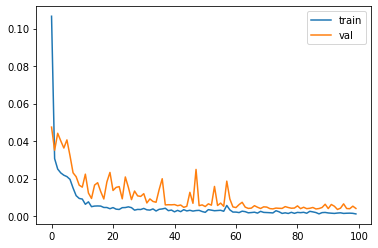

---Training time: 94.19313169 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# # Save the model
# print(model.summary())
# plot_model(model, show_shapes=True)
# model.save('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/Reference_p5270/Reference/DD_Transfer_model_70_10_20.h5')

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing 
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.99236, Train (V) - 0.96842
R2 scores: Validation (SS) - 0.96725, Validation (V) - 0.90717
R2 scores: Testing (SS) - 0.83826, Testing (V) - 0.79312
RMSE scores: Train (SS) - 0.01944, Train (V) - 0.02343
RMSE scores: Validation (SS) - 0.04237, Validation (V) - 0.04339
RMSE scores: Testing (SS) - 0.09226, Testing (V) - 0.06293


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

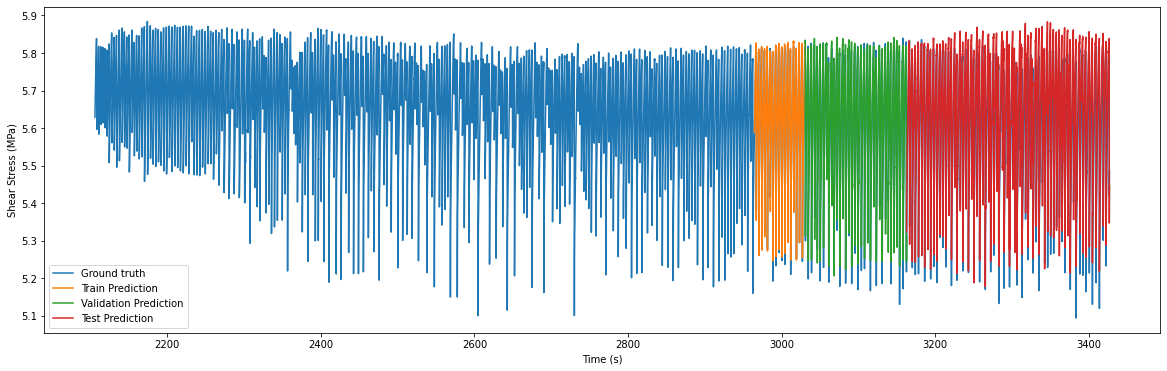

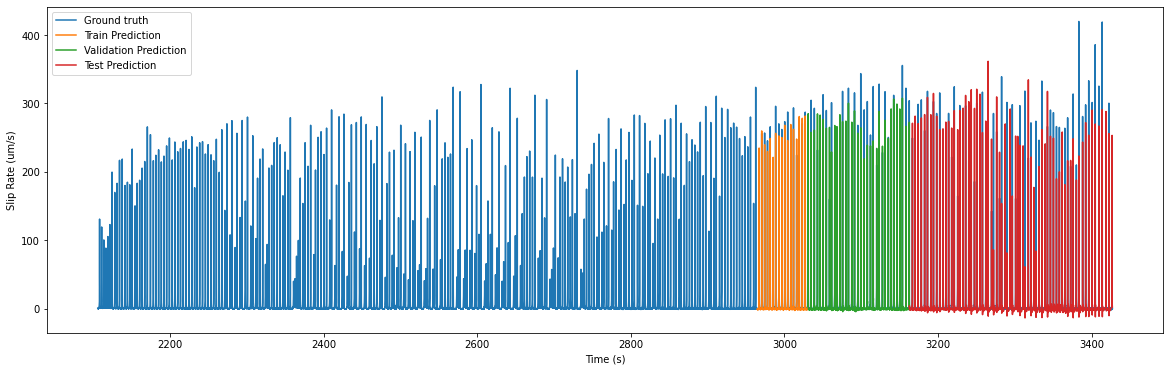

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[85864:92469] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

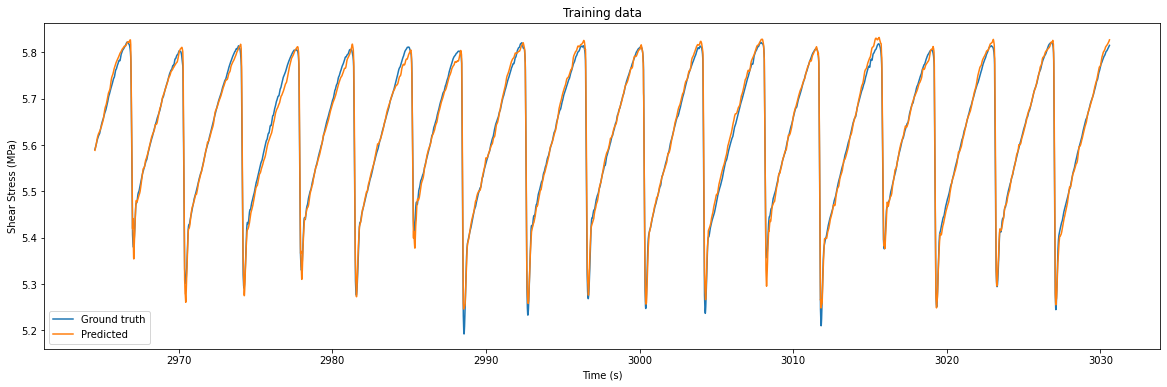

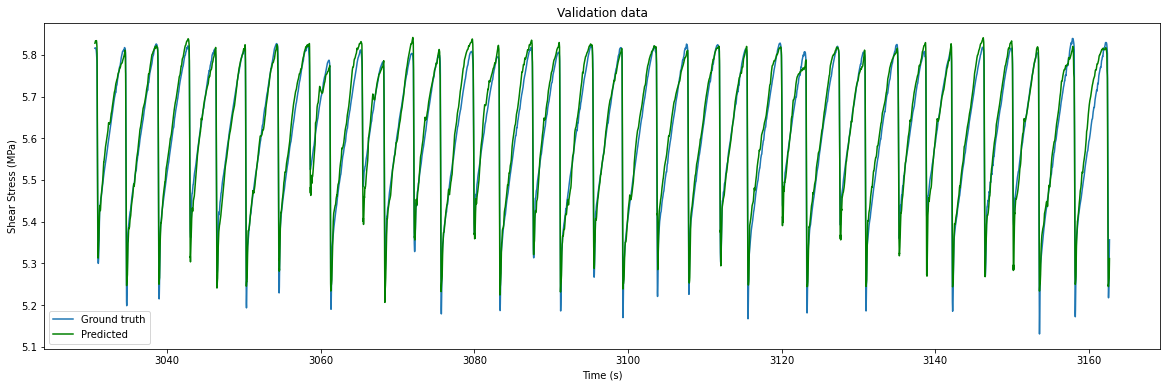

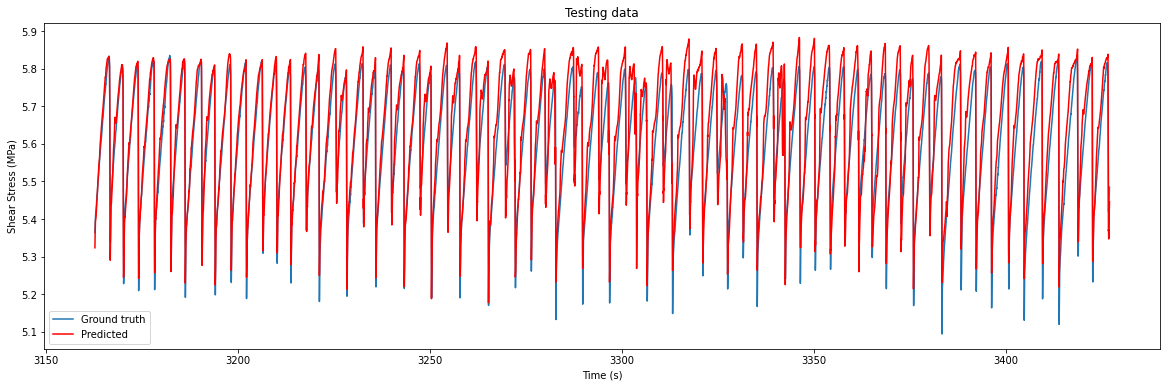

In [ ]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

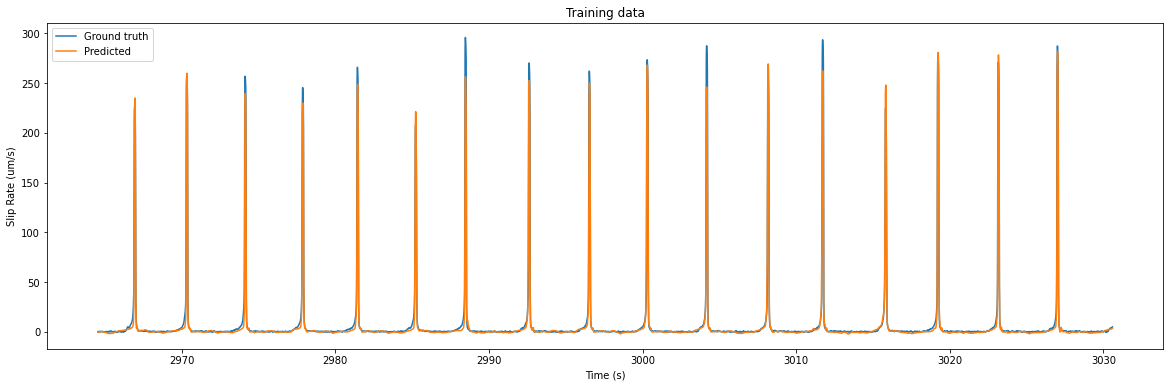

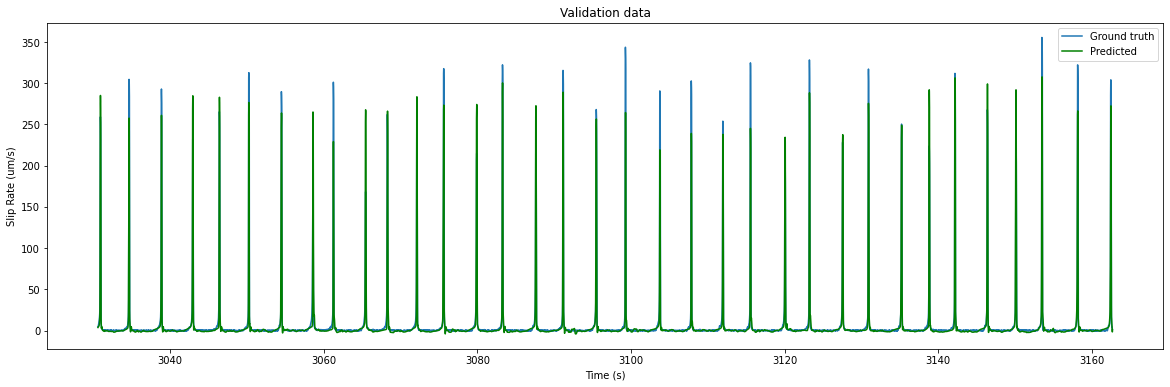

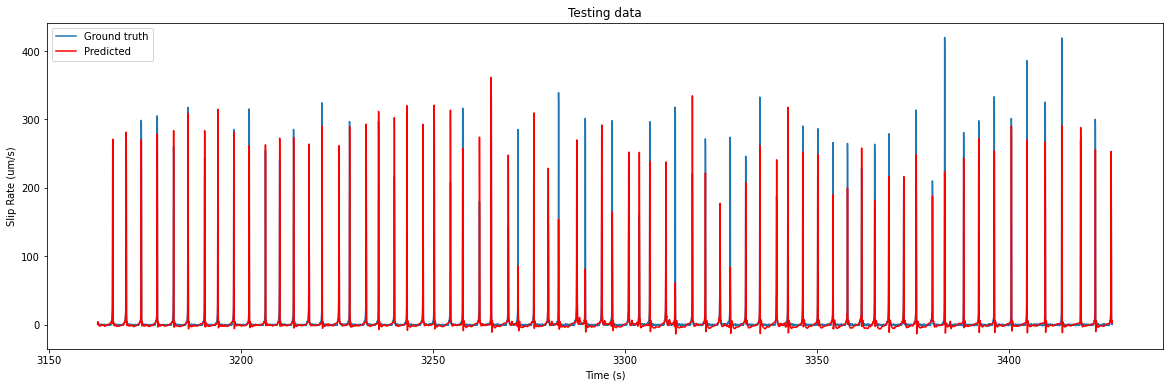

In [ ]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [ ]:
# # Extract Data

# # Time 
# savetxt('Whole_time.csv', ttime, delimiter=',')
# savetxt('traintime.csv', traintime, delimiter=',')
# savetxt('valtime.csv', valtime, delimiter=',')
# savetxt('testtime.csv', testtime, delimiter=',')

# # SS
# savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
# savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
# savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
# savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
# savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
# savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

# # V
# savetxt('Y_train_V.csv', Y_train_V, delimiter=',')
# savetxt('Y_val_V.csv', Y_val_V, delimiter=',')
# savetxt('y_test_V.csv', y_test_V, delimiter=',')
# savetxt('y_predtrain_V.csv', y_predtrain_V, delimiter=',')
# savetxt('y_predval_V.csv', y_predval_V, delimiter=',')
# savetxt('y_predtest_V.csv', y_predtest_V, delimiter=',')

# # Download
# files.download('Whole_time.csv')
# files.download('traintime.csv')
# files.download('valtime.csv')
# files.download('testtime.csv')

# files.download('Y_train_SS.csv')
# files.download('Y_val_SS.csv')
# files.download('y_test_SS.csv')
# files.download('y_predtrain_SS.csv')
# files.download('y_predval_SS.csv')
# files.download('y_predtest_SS.csv')

# files.download('Y_train_V.csv')
# files.download('Y_val_V.csv')
# files.download('y_test_V.csv')
# files.download('y_predtrain_V.csv')
# files.download('y_predval_V.csv')
# files.download('y_predtest_V.csv')